## Imports

In [37]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib import gridspec

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import gaussian_filter1d

## Helper Functions

In [7]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def plot_raster(sd, title):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title(title)
    plt.show()

def unpickle_object(filename):
    """
    Deserializes and returns an object from a file using the pickle protocol.

    Parameters:
    - filename: The name of the file from which the object will be loaded.

    Returns:
    - The Python object deserialized from the file.
    """
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
    return obj

def position_to_grid(pos):
    # Modify this function based on your grid conversion logic
    return pos[0], pos[1]  # Example conversion

def transform_neuron_data(sd):
    original_data = sd.neuron_data
    transformed_neuron_data = {'positions': {}}

    for top_level_key, clusters in original_data.items():
        for cluster_id, cluster_info in clusters.items():
            grid_pos = position_to_grid(cluster_info['position'])
            transformed_neuron_data['positions'][cluster_id] = {'position': grid_pos}

    return SpikeData(train=sd.train, length=sd.length, neuron_data=transformed_neuron_data)

## Plotting Function

In [71]:
def firing_plotter_with_raster(sd, global_min_rate, global_max_rate, time_windows, xsize=16, ysize=16):
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    window_colors = ['#ffcccb', '#add8e6', '#77dd77', '#ffd700', '#fdbcb4']
    
    fig = plt.figure(figsize=(xsize, ysize))
    # Adjust GridSpec to allocate more space to the top firing rate maps
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 1, 0.05], height_ratios=[1.5, 0.75, 0.75])
    fig.suptitle("Firing Rate by Time Window", fontsize=20)

    for i, (start_time, end_time) in enumerate(time_windows):
        ax = plt.subplot(gs[0, i])
        current_sd = sd.subtime(start_time * 1000, end_time * 1000)
        firing_rates = calculate_mean_firing_rates(current_sd)  # Placeholder for your function
        neuron_x, neuron_y = [], []

        for neuron in current_sd.neuron_data['positions'].values():
            neuron_x.append(neuron['position'][1])  # Rotate by swapping x and y
            neuron_y.append(neuron['position'][0])

        scatter = ax.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, cmap=cm, vmin=global_min_rate, vmax=global_max_rate, alpha=0.6)
        ax.set_title(f"{start_time}s to {end_time}s", fontsize=18)
        ax.set_xlabel("Y Position", fontsize=14)  
        if i == 0:
            ax.set_ylabel("X Position", fontsize=14)  
        else:
            ax.set_yticklabels([])

        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_aspect('equal')
        ax.set_xlim(500, 1800)  # Limit the x position to up to 1800
        ax.set_ylim(0, 2000)  # Limit the y position to up to 1000
        bottom_border_color = window_colors[i % len(window_colors)]
        ax.axhline(y=ax.get_ylim()[0], color=bottom_border_color, linewidth=7)

    overall_min_time = min(start for start, _ in time_windows)
    overall_max_time = max(end for _, end in time_windows)

    ax_raster = plt.subplot(gs[1, :-1])
    idces, times = sd.idces_times()
    ax_raster.scatter(times/1000, idces, marker='|', s=1)
    ax_raster.set_xlabel("Time (seconds)", fontsize=14)
    ax_raster.set_ylabel('Unit #', fontsize=14)
    ax_raster.set_title("Zoomed Raster Plot", fontsize=18)
    ax_raster.tick_params(axis='both', which='major', labelsize=12)
    ax_raster.set_xlim(overall_min_time, overall_max_time)

    for i, (start_time, end_time) in enumerate(time_windows):
        color = window_colors[i % len(window_colors)]
        ax_raster.axvspan(start_time, end_time, color=color, alpha=0.3)

    pop_rate = sd.binned(bin_size=1)  # Placeholder for your binning function
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=5)
    t = np.linspace(0, sd.length, len(pop_rate_smooth)) / 1000
    ax2 = ax_raster.twinx()
    ax2.plot(t, pop_rate_smooth, c='r')
    ax2.set_ylabel('Pop Rate (Hz)', fontsize=14)

    ax_raster_full = plt.subplot(gs[2, :-1])
    ax_raster_full.scatter(times/1000, idces, marker='|', s=1)
    ax_raster_full.set_xlim(0, sd.length / 1000)
    ax_raster_full.set_xlabel("Time (seconds)", fontsize=14)
    ax_raster_full.set_ylabel('Unit #', fontsize=14)
    ax_raster_full.set_title("Full Raster Plot", fontsize=18)
    ax_raster_full.tick_params(axis='both', which='major', labelsize=12)

    for i, (start_time, end_time) in enumerate(time_windows):
        color = window_colors[i % len(window_colors)]
        ax_raster_full.axvspan(start_time, end_time, color=color, alpha=0.3)

    # Adding right-hand Y-axis for population firing rate for the bottom raster plot
    ax2_full = ax_raster_full.twinx()
    ax2_full.plot(t, pop_rate_smooth, c='r')
    ax2_full.set_ylabel('Pop Rate (Hz)', fontsize=14)

    # Setup colorbar axis to match only the height of the top row of firing rate plots
    cbar_ax = plt.subplot(gs[0, -1])
    cbar = fig.colorbar(scatter, cax=cbar_ax, label='Firing Rate (Hz)')
    cbar.set_label('Firing Rate (Hz)', size=14)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [108]:
def firing_plotter_with_raster(sd, global_min_rate, global_max_rate, time_windows, xsize=8, ysize=8):
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    window_colors = ['#ffcccb', '#add8e6', '#77dd77', '#ffd700', '#fdbcb4']
    
    fig = plt.figure(figsize=(xsize, ysize))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 1, 0.05], height_ratios=[1.5, 0.75, 0.75])
    fig.suptitle("Firing Rate by Time Window", fontsize=16, y = 0.92)

    for i, (start_time, end_time) in enumerate(time_windows):
        ax = plt.subplot(gs[0, i])
        current_sd = sd.subtime(start_time * 1000, end_time * 1000)
        firing_rates = calculate_mean_firing_rates(current_sd)
        neuron_x, neuron_y = [], []

        for neuron in current_sd.neuron_data['positions'].values():
            neuron_x.append(neuron['position'][1])  # Rotate by swapping x and y
            neuron_y.append(neuron['position'][0])

        scatter = ax.scatter(neuron_x, neuron_y, s=firing_rates, c=firing_rates, cmap=cm, vmin=global_min_rate, vmax=global_max_rate, alpha=0.6)
        ax.set_title(f"{start_time}s to {end_time}s", fontsize=14)
        ax.set_xlabel("Y Position", fontsize=10)
        if i == 0:
            ax.set_ylabel("X Position", fontsize=10)
        else:
            ax.set_yticklabels([])
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal')
        ax.set_xlim(500, 1800)
        ax.set_ylim(0, 2000)
        bottom_border_color = window_colors[i % len(window_colors)]
        ax.axhline(y=ax.get_ylim()[0], color=bottom_border_color, linewidth=5)

    overall_min_time = min(start for start, _ in time_windows)
    overall_max_time = max(end for _, end in time_windows)

    ax_raster = plt.subplot(gs[1, :-1])
    idces, times = sd.idces_times()
    ax_raster.scatter(times / 1000, idces, marker='|', s=1)
    ax_raster.set_xlabel("Time (seconds)", fontsize=10)
    ax_raster.set_ylabel('Unit #', fontsize=10)
    ax_raster.set_title("Zoomed Raster Plot", fontsize=14)
    ax_raster.tick_params(axis='both', which='major', labelsize=8)
    ax_raster.set_xlim(overall_min_time, overall_max_time)

    for i, (start_time, end_time) in enumerate(time_windows):
        color = window_colors[i % len(window_colors)]
        ax_raster.axvspan(start_time, end_time, color=color, alpha=0.3)

    pop_rate = sd.binned(bin_size=1)  # Placeholder for your binning function
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=5)
    t = np.linspace(0, sd.length, len(pop_rate_smooth)) / 1000
    ax2 = ax_raster.twinx()
    ax2.plot(t, pop_rate_smooth, c='r', linewidth=1)
    ax2.set_ylabel('Pop Rate (Hz)', fontsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=8)

    ax_raster_full = plt.subplot(gs[2, :-1])
    ax_raster_full.scatter(times/1000, idces, marker='|', s=1)
    ax_raster_full.set_xlim(0, sd.length / 1000)
    ax_raster_full.set_xlabel("Time (seconds)", fontsize=10)
    ax_raster_full.set_ylabel('Unit #', fontsize=10)
    ax_raster_full.set_title("Full Raster Plot", fontsize=14)
    ax_raster_full.tick_params(axis='both', which='major', labelsize=8)

    for i, (start_time, end_time) in enumerate(time_windows):
        color = window_colors[i % len(window_colors)]
        ax_raster_full.axvspan(start_time, end_time, color=color, alpha=0.3)

    ax2_full = ax_raster_full.twinx()
    ax2_full.plot(t, pop_rate_smooth, c='r', linewidth=1)
    ax2_full.set_ylabel('Pop Rate (Hz)', fontsize=10)
    ax2_full.tick_params(axis='both', which='major', labelsize=8)

    # Setup colorbar axis to match only the height of the top row of firing rate plots
    cbar_ax = plt.subplot(gs[0, -1])
    fig.colorbar(scatter, cax=cbar_ax, label='Firing Rate (Hz)').set_label('Firing Rate (Hz)', size=14)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
def firing_plotter_with_raster(sd, global_min_rate, global_max_rate, time_windows, xsize=8, ysize=8):
    # Define the colormap
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    # Define window colors
    window_colors = ['#ffcccb', '#add8e6', '#77dd77', '#ffd700', '#fdbcb4']
    
    # Initialize the figure and gridspec
    fig = plt.figure(figsize=(xsize, ysize))
    gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 1, 1, 0.05], height_ratios=[1, 0.5, 0.5], wspace=0.3, hspace=0.1)
    fig.suptitle("Firing Rate by Time Window", fontsize=16, y=0.93)
    
    # Plot firing rate maps
    for i, (start_time, end_time) in enumerate(time_windows):
        ax = plt.subplot(gs[0, i])
        current_sd = sd.subtime(start_time * 1000, end_time * 1000)
        firing_rates = calculate_mean_firing_rates(current_sd)  # Placeholder for your function
        neuron_x, neuron_y = [], []

        for neuron in current_sd.neuron_data['positions'].values():
            neuron_x.append(neuron['position'][1])  # Rotate by swapping x and y
            neuron_y.append(neuron['position'][0])

        scatter = ax.scatter(neuron_x, neuron_y, s=firing_rates * 1.5, c=firing_rates, cmap=cm, vmin=global_min_rate, vmax=global_max_rate, alpha=0.6)
        ax.set_title(f"{start_time}s to {end_time}s", fontsize=14)
        ax.set_xlabel("Y Position", fontsize=12)
        if i == 0:
            ax.set_ylabel("X Position", fontsize=12)
        else:
            ax.set_yticklabels([])
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(500, 1800)
        ax.set_ylim(0, 2000)

    # Adjustments to the raster plots and population rate are below
    
    # Placeholder for idces_times and binned function calls
    # These should be replaced with your actual data processing and plotting logic
    idces, times = np.random.randint(1, 100, 1000), np.random.randint(0, 3000, 1000)  # Example data
    pop_rate = np.random.rand(300) * 10  # Example data
    pop_rate_smooth = gaussian_filter1d(pop_rate.astype(float), sigma=2)
    t = np.linspace(0, 300, len(pop_rate_smooth))

    # Zoomed raster plot
    ax_raster = plt.subplot(gs[1, :-1])
    ax_raster.scatter(times, idces, marker='|', s=1)
    ax_raster.set_xlim(0, max(times))
    ax_raster.set_ylim(0, max(idces))
    ax_raster.set_xlabel("Time (s)", fontsize=12)
    ax_raster.set_ylabel("Unit #", fontsize=12)
    
    # Full raster plot
    ax_raster_full = plt.subplot(gs[2, :-1])
    ax_raster_full.scatter(times, idces, marker='|', s=1)
    ax_raster_full.set_xlim(0, max(times))
    ax_raster_full.set_ylim(0, max(idces))
    ax_raster_full.set_xlabel("Time (s)", fontsize=12)
    ax_raster_full.set_ylabel("Unit #", fontsize=12)

    # Population rate plot on the right of





## Data

In [8]:
from human_hip import spike_data

dataset1 = spike_data.read_autocurated_data('data/Hc112723_hckcr1_21841_120323_base_acqm.zip')
dataset1 = transform_neuron_data(dataset1)

/tmp/ipykernel_6646/1755728250.py:52: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  original_data = sd.neuron_data


In [24]:
# Max and min neuron positions

# Get the neuron positions for dataset1
neuron_positions = get_neuron_positions(dataset1)

# Calculate the max and min neuron positions
max_x, max_y = neuron_positions.max(axis=0)
min_x, min_y = neuron_positions.min(axis=0)

# Print the max and min neuron positions
print(f"Max Neuron Position: ({max_x}, {max_y})")
print(f"Min Neuron Position: ({min_x}, {min_y})")

Max Neuron Position: (2502.5, 1732.5)
Min Neuron Position: (210.0, 717.5)


/tmp/ipykernel_6646/1755728250.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in spike_data.neuron_data['positions'].values():


## Plots

/tmp/ipykernel_6646/880341061.py:19: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():
/tmp/ipykernel_6646/880341061.py:19: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():
/tmp/ipykernel_6646/880341061.py:19: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():


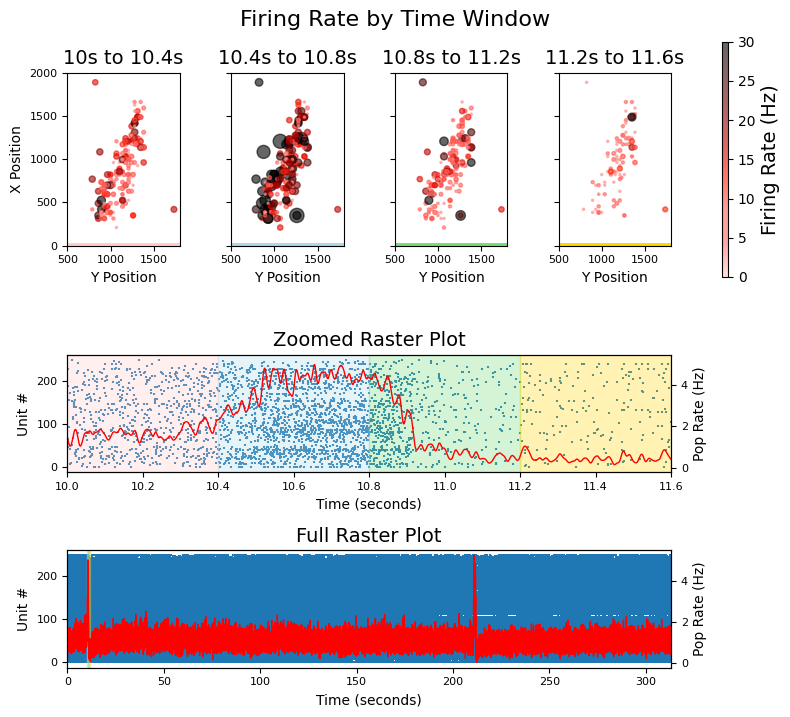

In [107]:
firing_plotter_with_raster(dataset1, 0, 30, [(10, 10.4), (10.4, 10.8), (10.8, 11.2), (11.2, 11.6)])

/tmp/ipykernel_22302/3417487186.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_22302/3417487186.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_22302/3417487186.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists


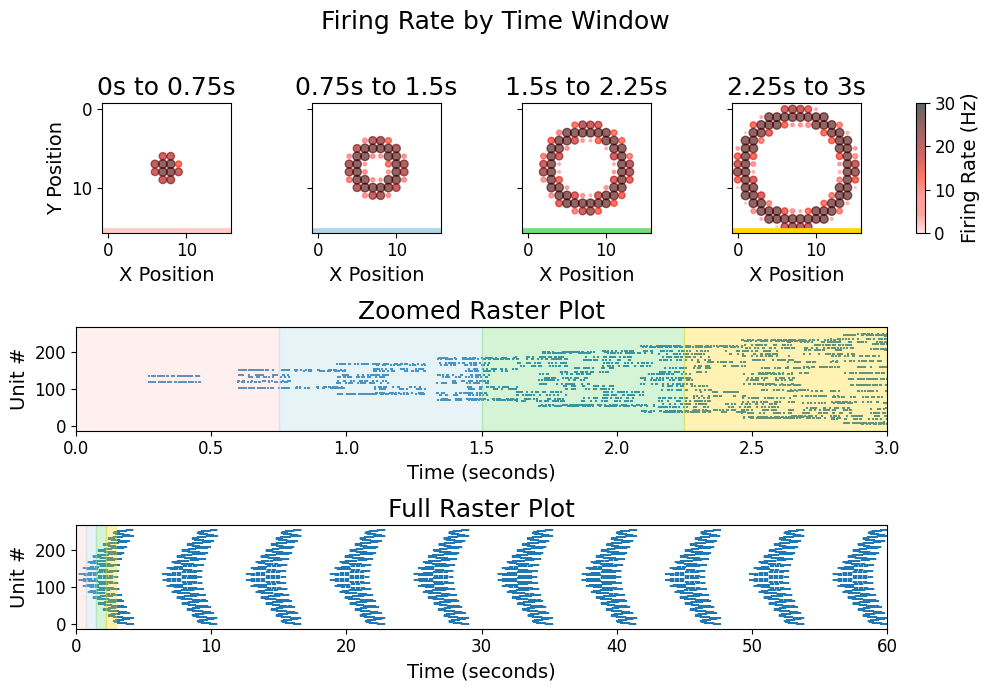

In [13]:
firing_plotter_with_raster(circular_spike_data, 0, 30, [(0, 0.75), (0.75, 1.5), (1.5, 2.25), (2.25, 3)])

/tmp/ipykernel_22302/3417487186.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_22302/3417487186.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_22302/3417487186.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists


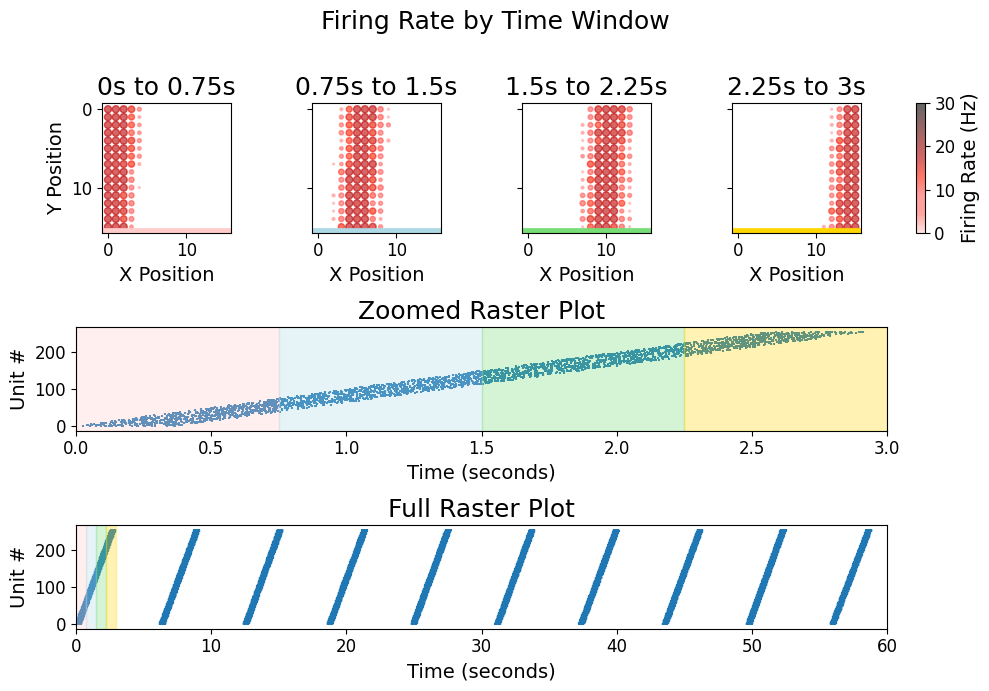

In [14]:
firing_plotter_with_raster(linear_spike_data, 0, 30, [(0, 0.75), (0.75, 1.5), (1.5, 2.25), (2.25, 3)])

/tmp/ipykernel_22302/3417487186.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_22302/3417487186.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
/tmp/ipykernel_22302/3417487186.py:23: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists


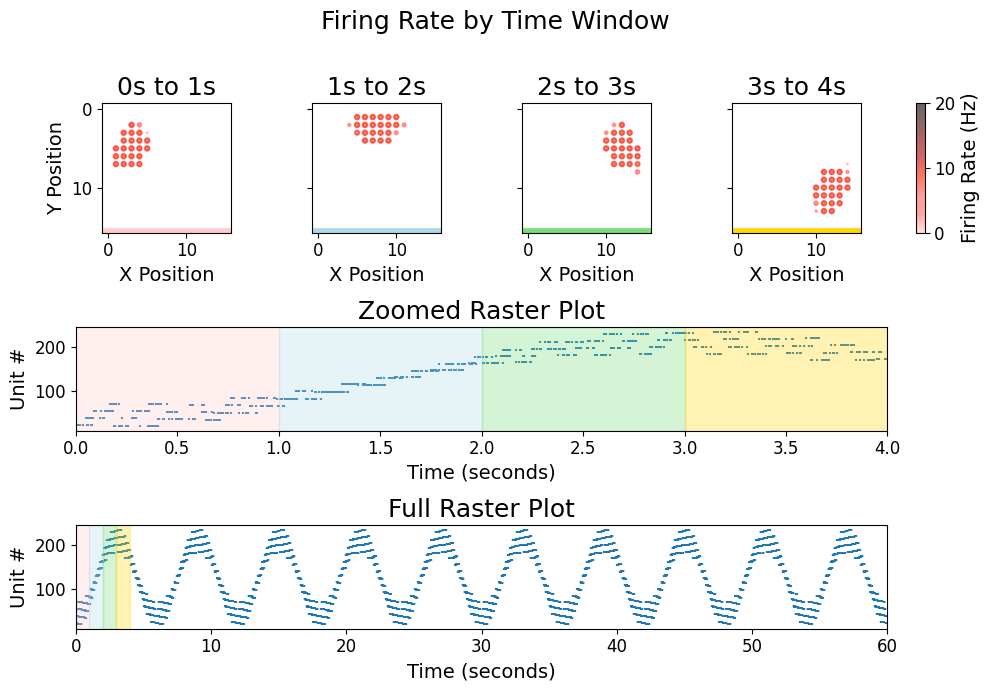

In [15]:
firing_plotter_with_raster(continuous_loop_spike_data, 0, 20, [(0, 1), (1, 2), (2, 3), (3, 4)])